# 專案：應用於臺北捷運時序資料深度學習分析

## 筆記本 02：探索性資料分析 (EDA) 與特徵工程

**目標：**
1.  讀取上一階段處理好的時間序列資料。
2.  透過視覺化方法探索資料中的模式、週期與趨勢。
3.  從時間戳中建立多種特徵，以供後續模型學習。

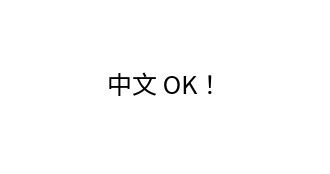

In [1]:
# -*- coding: utf-8 -*-
"""
下載並註冊 Noto Sans CJK TC，設定 Matplotlib 可顯示中文字
"""

import os, pathlib, shutil, importlib, requests
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# ---------------------------- 1️⃣ 準備字體檔 ----------------------------
FONT_URL  = ("https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/"
             "TraditionalChinese/NotoSansCJKtc-Regular.otf")   # 官方 GitHub 直鏈
FONT_PATH = pathlib.Path("NotoSansCJKtc-Regular.otf")

if not FONT_PATH.exists():                          # 檔案不存在就下載
    print("⏬ 下載中文字體…")
    with requests.get(FONT_URL, stream=True, timeout=30) as r:  # stream 節省記憶體
        r.raise_for_status()                                     # 失敗時丟例外
        with open(FONT_PATH, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    print("✅ 下載完成 →", FONT_PATH.resolve())

# ---------------------------- 2️⃣ 登錄字體 ----------------------------
fm.fontManager.addfont(str(FONT_PATH))              # addfont ≒ 把檔案掛進 FontManager :contentReference[oaicite:0]{index=0}

# 3.10 之後官方移除 _rebuild；用 findfont(rebuild_if_missing=True) 即可重掃字體快取
fm.findfont("Noto Sans CJK TC", rebuild_if_missing=True)   # 刷新快取並驗證字體存在 :contentReference[oaicite:1]{index=1}

# ---------------------------- 3️⃣ 設定 rcParams ----------------------------
plt.rcParams.update({
    "font.family": "sans-serif",                               # 先告訴 Matplotlib 用 sans-serif :contentReference[oaicite:2]{index=2}
    "font.sans-serif": ["Noto Sans CJK TC", "DejaVu Sans"],    # 有破折號只能這樣設定 :contentReference[oaicite:3]{index=3}
    "axes.unicode_minus": False                                # 避免負號顯示方框 :contentReference[oaicite:4]{index=4}
})

# ---------------------------- 4️⃣ 測試繪圖 ----------------------------
fig, ax = plt.subplots(figsize=(4, 2))
ax.text(0.5, 0.5, "中文 OK！", ha="center", va="center", fontsize=18)
ax.set_axis_off()
plt.show()

## 步驟一：讀取資料與載入函式庫

此步驟將載入所有分析所需的 Python 函式庫，並從前一個 Notebook (`01`) 儲存的 `.pkl` 檔案中讀取已清理、彙總、且時間對齊的 DataFrame。

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

# --- 讀取已處理好的資料 ---
# 假設您的新 Notebook 也在 'notebooks' 資料夾中
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_path = os.path.join(project_root, 'data', 'processed', 'station_timeseries_final_202301_202504.pkl')

# 檢查檔案是否存在
if os.path.exists(data_path):
    df = pd.read_pickle(data_path)
    print("✅ 資料讀取成功！")
else:
    print(f"❌ 錯誤：找不到資料檔案於 {data_path}")
    df = pd.DataFrame() # 建立一個空的 DataFrame 以免後續出錯

# --- 驗證讀取結果 ---
if not df.empty:
    print("\n--- DataFrame 基本資訊 ---")
    df.info()
    
    print("\n--- 資料預覽 (前5筆) ---")
    display(df.head())

✅ 資料讀取成功！

--- DataFrame 基本資訊 ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20424 entries, 2023-01-01 00:00:00 to 2025-04-30 23:00:00
Freq: h
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   進站人次    20424 non-null  int64
 1   出站人次    20424 non-null  int64
 2   總人次     20424 non-null  int64
dtypes: int64(3)
memory usage: 638.2 KB

--- 資料預覽 (前5筆) ---


,進站人次,出站人次,總人次
時間戳,,,
2023-01-01 00:00:00,1882,282,2164
2023-01-01 01:00:00,35,0,35
2023-01-01 02:00:00,0,0,0
2023-01-01 03:00:00,0,0,0
2023-01-01 04:00:00,0,0,0


## 步驟二：特徵工程 (Feature Engineering)

我們的目標是從「時間戳」這個看似單一的資訊中，提煉出更多可供機器學習模型使用的、結構化的資訊，例如「現在是幾點鐘？」、「今天是星期幾？」、「是否為週末？」等等。這些新建的欄位（特徵）對於捕捉時間序列的週期性至關重要。

In [3]:
def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    從 DataFrame 的 DatetimeIndex 中建立時間相關特徵。
    """
    # 創建一個 df 的副本，避免修改到原始 df
    df_copy = df.copy()
    
    # 從時間戳索引(df.index)中提取特徵
    df_copy['hour'] = df_copy.index.hour
    df_copy['dayofweek'] = df_copy.index.dayofweek  # 週一=0, 週日=6
    df_copy['quarter'] = df_copy.index.quarter
    df_copy['month'] = df_copy.index.month
    df_copy['year'] = df_copy.index.year
    df_copy['dayofyear'] = df_copy.index.dayofyear
    df_copy['dayofmonth'] = df_copy.index.day
    df_copy['weekofyear'] = df_copy.index.isocalendar().week.astype(int)
    
    # 建立一個布林型的特徵，標示是否為週末
    df_copy['is_weekend'] = (df_copy.index.dayofweek >= 5).astype(int) # 週末為1, 平日為0
    
    return df_copy

# 檢查 df 是否存在
if 'df' in locals() and not df.empty:
    # 執行特徵工程函數
    df_featured = create_time_features(df)
    
    print("✅ 特徵工程完成！")
    print("\n--- 建立特徵後的 DataFrame (前5筆) ---")
    display(df_featured.head())
else:
    print("❌ 錯誤：找不到 DataFrame 'df'。")

✅ 特徵工程完成！

--- 建立特徵後的 DataFrame (前5筆) ---


,進站人次,出站人次,總人次,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend
時間戳,,,,,,,,,,,,
2023-01-01 00:00:00,1882,282,2164,0,6,1,1,2023,1,1,52,1
2023-01-01 01:00:00,35,0,35,1,6,1,1,2023,1,1,52,1
2023-01-01 02:00:00,0,0,0,2,6,1,1,2023,1,1,52,1
2023-01-01 03:00:00,0,0,0,3,6,1,1,2023,1,1,52,1
2023-01-01 04:00:00,0,0,0,4,6,1,1,2023,1,1,52,1


## 步驟三：視覺化分析 (EDA)
利用剛剛建立的時間特徵，透過圖表深入觀察旅運量的週期性模式。我們將使用箱型圖(Box Plot)和熱力圖(Heatmap)來探索資料。

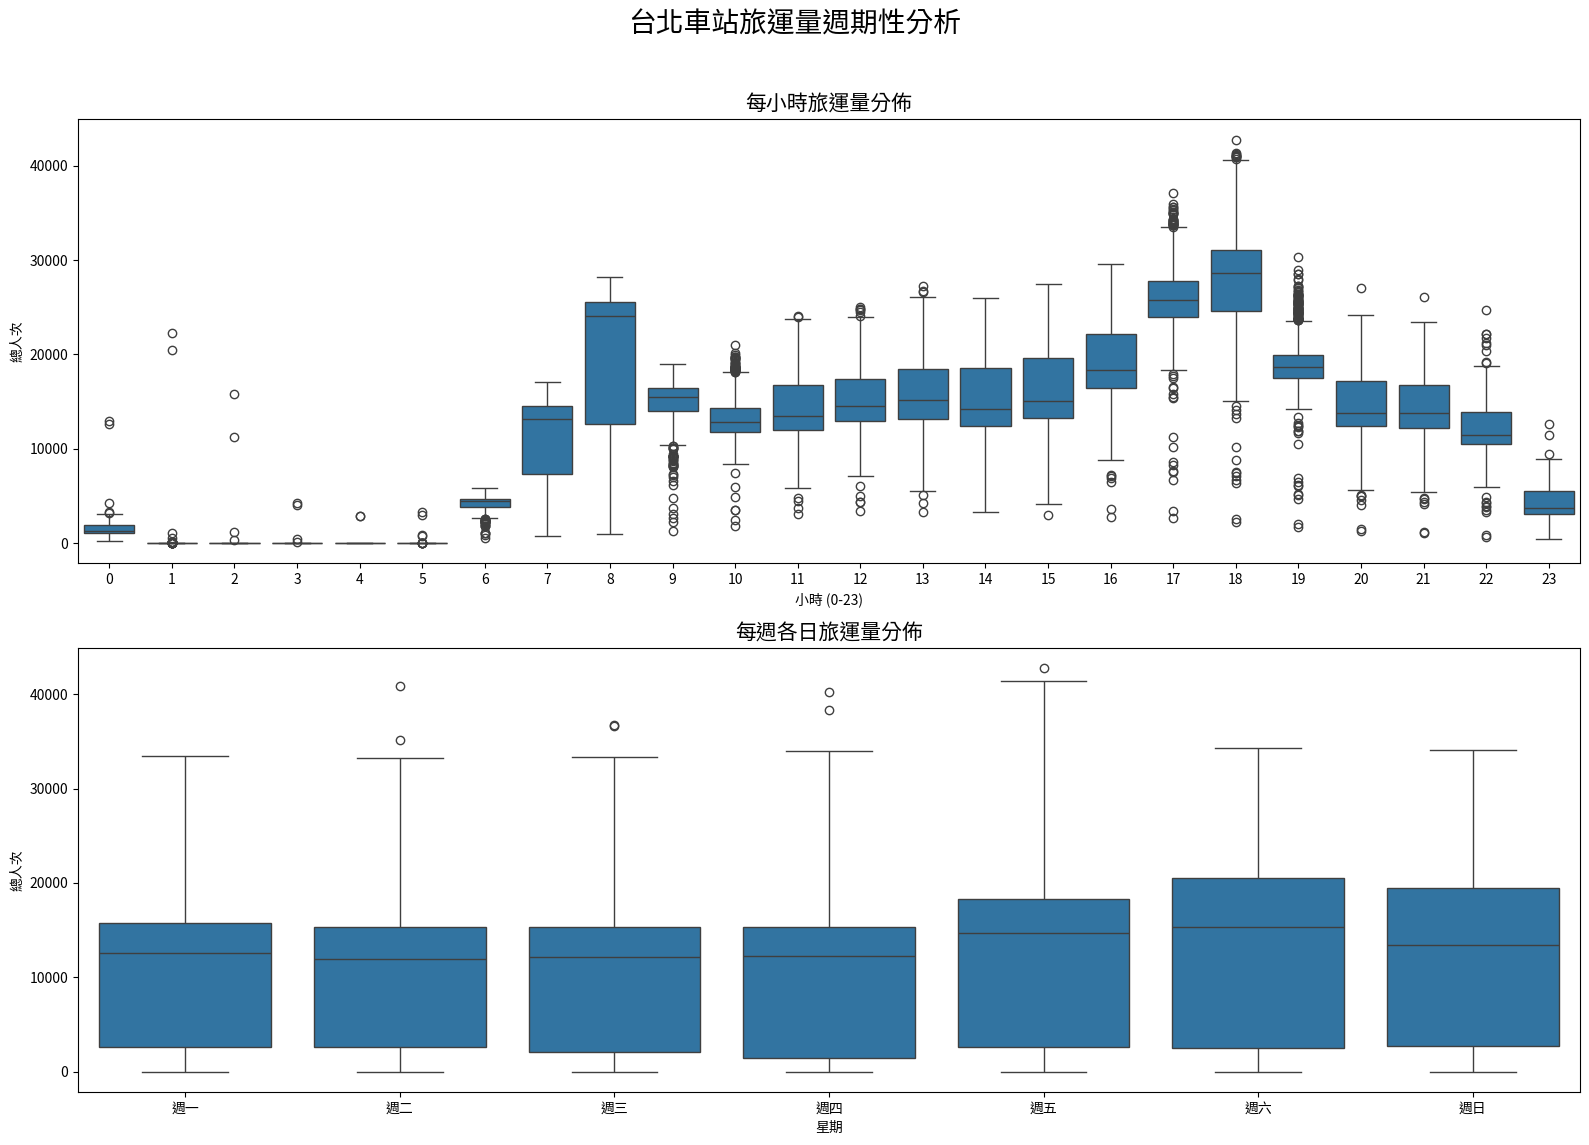

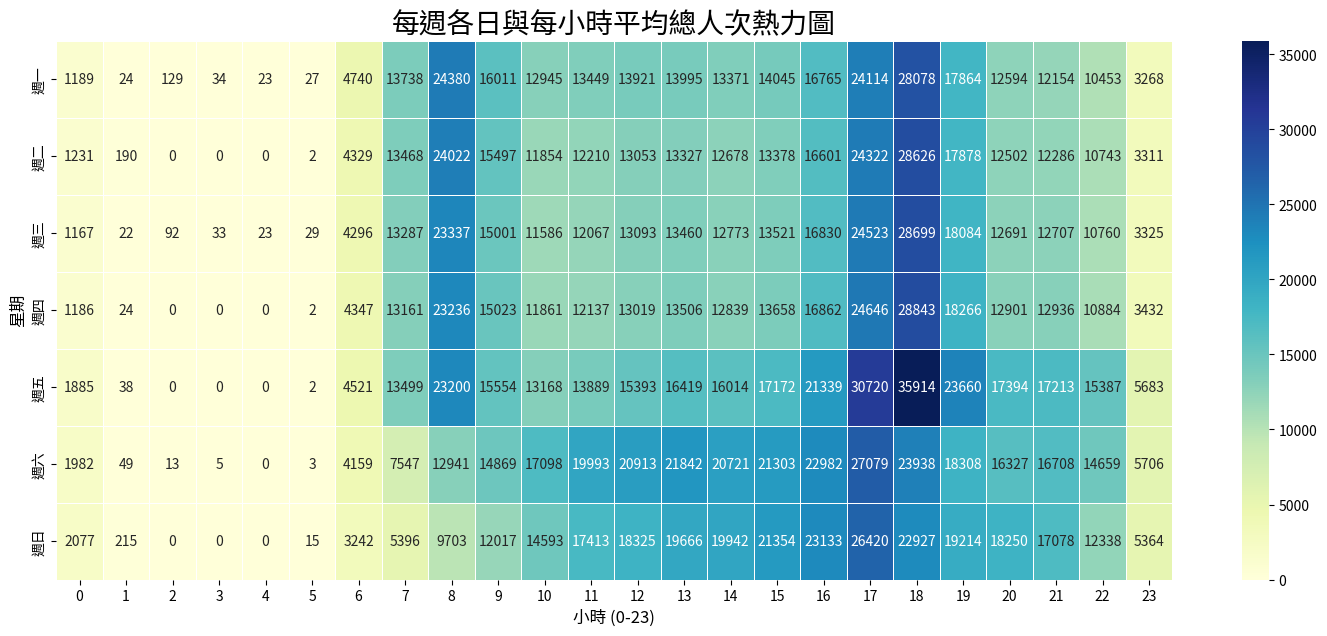

In [ ]:
if 'df_featured' in locals():
    # --- 視覺化 1: 箱型圖分析 ---
    fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharey=True)
    fig.suptitle('台北車站旅運量週期性分析', fontsize=20)

    # 1. 每小時旅運分佈
    sns.boxplot(ax=axes[0], data=df_featured, x='hour', y='總人次')
    axes[0].set_title('每小時旅運量分佈', fontsize=15)
    axes[0].set_xlabel('小時 (0-23)')
    axes[0].set_ylabel('總人次')

    # 2. 每週旅運分佈
    weekday_map = {0: '週一', 1: '週二', 2: '週三', 3: '週四', 4: '週五', 5: '週六', 6: '週日'}
    df_featured['dayofweek_str'] = df_featured['dayofweek'].map(weekday_map)
    sns.boxplot(ax=axes[1], data=df_featured, x='dayofweek_str', y='總人次', 
                order=['週一', '週二', '週三', '週四', '週五', '週六', '週日'])
    axes[1].set_title('每週各日旅運量分佈', fontsize=15)
    axes[1].set_xlabel('星期')
    axes[1].set_ylabel('總人次')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

    # --- 視覺化 2: 熱力圖分析 ---
    pivot_table = df_featured.pivot_table(values='總人次', index='dayofweek_str', columns='hour', aggfunc='mean')
    pivot_table = pivot_table.loc[['週一', '週二', '週三', '週四', '週五', '週六', '週日']]

    plt.figure(figsize=(18, 7))
    sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=.5)
    plt.title('每週各日與每小時平均總人次熱力圖', fontsize=20)
    plt.xlabel('小時 (0-23)', fontsize=12)
    plt.ylabel('星期', fontsize=12)
    plt.show()

else:
    print("❌ 錯誤：找不到 df_featured，請先執行前面的『特徵工程』儲存格。")

## 步驟四：模型建立前的準備
此步驟包含將時間序列資料轉換為適合神經網路訓練的格式，是建模前最關鍵的資料處理環節。
1.  **資料分割 (Train/Test Split)**：按 80/20 的時間順序分割資料。
2.  **資料縮放 (Scaling)**：使用 `MinMaxScaler` 將所有特徵值縮放到 [0, 1] 區間。
3.  **建立監督式學習序列**：將資料轉換為 (過去一段時間的特徵, 未來要預測的值) 的格式。

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

if 'df_featured' in locals():
    # --- 4.1 資料分割 (Training/Test Split) ---
    split_ratio = 0.8
    split_index = int(len(df_featured) * split_ratio)
    
    train_df = df_featured.iloc[:split_index]
    test_df = df_featured.iloc[split_index:]

    print("--- 4.1 資料分割結果 ---")
    print(f"訓練集筆數: {len(train_df):,} (從 {train_df.index.min()} 到 {train_df.index.max()})")
    print(f"測試集筆數: {len(test_df):,} (從 {test_df.index.min()} 到 {test_df.index.max()})")

    # --- 4.2 資料縮放 (Scaling) ---
    target_col = '總人次'
    # 移除字串型態的 'dayofweek_str' 欄位，它只用於繪圖
    features = [col for col in df_featured.columns if col not in [target_col, 'dayofweek_str']]

    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # 在訓練集上學習並轉換
    train_df_scaled_features = feature_scaler.fit_transform(train_df[features])
    train_df_scaled_target = target_scaler.fit_transform(train_df[[target_col]])

    # 在測試集上只進行轉換
    test_df_scaled_features = feature_scaler.transform(test_df[features])
    test_df_scaled_target = target_scaler.transform(test_df[[target_col]])
    
    # 將縮放後的資料合併回 DataFrame
    train_scaled = pd.DataFrame(train_df_scaled_features, columns=features, index=train_df.index)
    train_scaled[target_col] = train_df_scaled_target

    test_scaled = pd.DataFrame(test_df_scaled_features, columns=features, index=test_df.index)
    test_scaled[target_col] = test_df_scaled_target
    
    print("\n--- 4.2 資料縮放完成 ---")

    # --- 4.3 建立監督式學習序列 ---
    def create_sequences(data, target_col, n_past, n_future=1):
        X, y = [], []
        # 從 data 中移除 target 以外的原始人次欄位
        feature_data = data.drop(columns=['進站人次', '出站人次']).values
        target_data = data[target_col].values
        
        for i in range(len(data) - n_past - n_future + 1):
            X.append(feature_data[i:(i + n_past)])
            y.append(target_data[i + n_past:i + n_past + n_future])
        return np.array(X), np.array(y)

    # 設定：用過去 24 小時的資料，預測未來 1 小時的人次
    N_PAST = 24
    N_FUTURE = 1

    X_train, y_train = create_sequences(train_scaled, target_col, N_PAST, N_FUTURE)
    X_test, y_test = create_sequences(test_scaled, target_col, N_PAST, N_FUTURE)

    print("\n--- 4.3 序列建立完成 ---")
    print(f"使用過去 {N_PAST} 小時的資料，預測未來 {N_FUTURE} 小時。")
    print(f"訓練集 X 的形狀: {X_train.shape}")
    print(f"訓練集 y 的形狀: {y_train.shape}")
    print(f"測試集 X 的形狀: {X_test.shape}")
    print(f"測試集 y 的形狀: {y_test.shape}")
    
else:
    print("❌ 錯誤：找不到 df_featured")

--- 4.1 資料分割結果 ---
訓練集筆數: 16,339 (從 2023-01-01 00:00:00 到 2024-11-11 18:00:00)
測試集筆數: 4,085 (從 2024-11-11 19:00:00 到 2025-04-30 23:00:00)

--- 4.2 資料縮放完成 ---

--- 4.3 序列建立完成 ---
使用過去 24 小時的資料，預測未來 1 小時。
訓練集 X 的形狀: (16315, 24, 10)
訓練集 y 的形狀: (16315, 1)
測試集 X 的形狀: (4061, 24, 10)
測試集 y 的形狀: (4061, 1)


## 步驟五：建立與訓練 LSTM 模型
萬事俱備，只欠東風。我們將使用 Keras 建立一個 LSTM 神經網路模型，並用準備好的訓練資料對其進行訓練。
- **模型架構**: Input -> LSTM Layer -> Dropout -> LSTM Layer -> Dropout -> Dense Layer (Output)
- **損失函數**: `mean_squared_error` (均方誤差)，適用於迴歸預測問題。
- **優化器**: `adam`，一種高效且常用的優化算法。

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 建立 LSTM 模型 (已修正) ---
input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential([
    # 修正點：加入 recurrent_dropout 參數以使用標準 LSTM 核心
    LSTM(64, return_sequences=True, input_shape=input_shape, recurrent_dropout=0.1),
    Dropout(0.2),
    
    # 修正點：在第二層也加入
    LSTM(32, return_sequences=False, recurrent_dropout=0.1),
    Dropout(0.2),

    Dense(1)
])

# 編譯模型 (此部分不變)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# --- 訓練模型 (此部分不變) ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', save_best_only=True, monitor='val_loss')

print("\n--- 開始訓練模型 ---")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("\n--- 模型訓練完成 ---")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)


--- 開始訓練模型 ---
Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 0.0394 - val_loss: 0.0147
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0156 - val_loss: 0.0147
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0122 - val_loss: 0.0080
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0093 - val_loss: 0.0062
Epoch 5/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0076 - val_loss: 0.0043
Epoch 6/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.0066 - val_loss: 0.0045
Epoch 7/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 8/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 9/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 10/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 11/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 12/50
25

## 步驟六：模型評估與結果視覺化
模型訓練完成後，我們需要評估其預測的準確性，並將結果視覺化，以直觀地了解模型的表現。
1.  **繪製學習曲線**：觀察模型在訓練過程中的學習狀況。
2.  **執行預測**：使用訓練好的模型對測試集進行預測。
3.  **反向縮放**：將預測結果和真實值還原到原始的「人次」尺度。
4.  **計算評估指標**：使用 MAE、RMSE 等指標量化模型誤差。
5.  **視覺化預測結果**：將預測值與真實值繪製在同一張圖上進行比較。

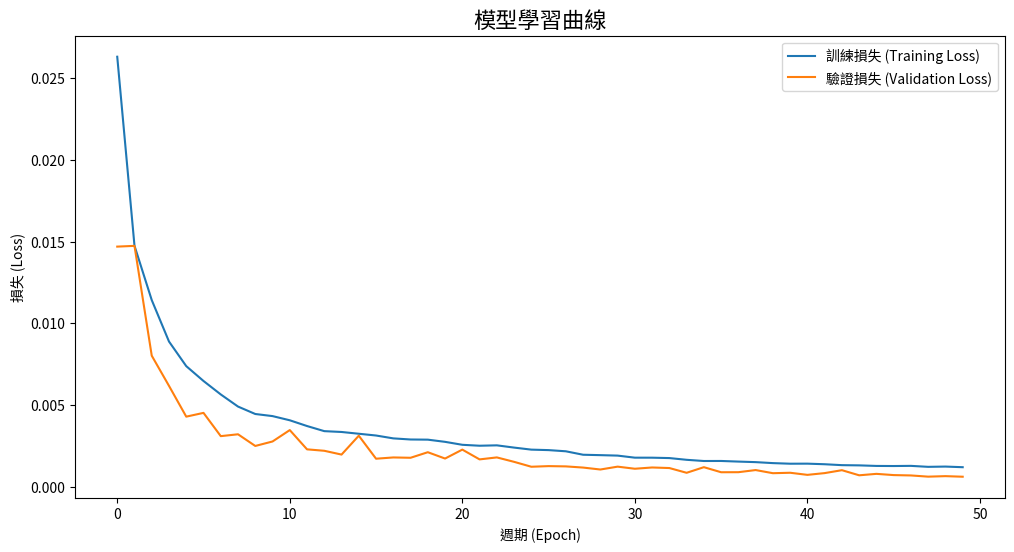

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

--- 6.3 預測結果反向縮放完成 ---
預測結果的前5筆 (原始人次): 
[18935 12626 12140 10699  2748]
真實結果的前5筆 (原始人次): 
[18191 12482 12240 11790  3173]

--- 6.4 模型評估指標 (在測試集上) ---
平均絕對誤差 (MAE): 625.42
均方根誤差 (RMSE): 1023.55

指標解釋：
MAE = 625.42 表示我們的模型預測的每小時總人次，平均來說與真實值相差約 625 人。


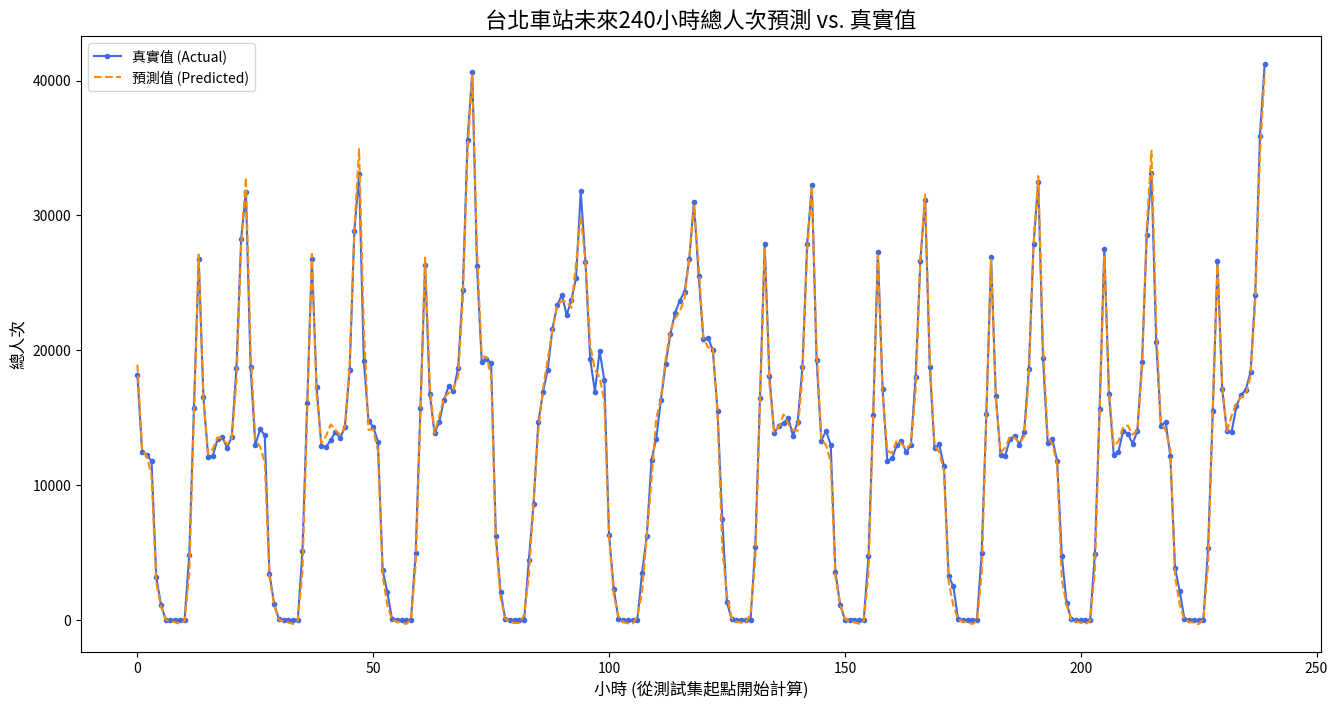

In [8]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 6.1 繪製學習曲線 ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='訓練損失 (Training Loss)')
plt.plot(history.history['val_loss'], label='驗證損失 (Validation Loss)')
plt.title('模型學習曲線', fontsize=16)
plt.xlabel('週期 (Epoch)')
plt.ylabel('損失 (Loss)')
plt.legend()
plt.show()

# --- 6.2 載入最佳模型並執行預測 ---
# 載入在訓練過程中儲存的、驗證損失最低的模型
best_model = load_model('best_lstm_model.keras')
predictions_scaled = best_model.predict(X_test)

# --- 6.3 反向縮放，還原至原始尺度 ---
# 我們之前用 target_scaler 來縮放 '總人次'，現在用它來反向還原
predictions = target_scaler.inverse_transform(predictions_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

print("\n--- 6.3 預測結果反向縮放完成 ---")
print(f"預測結果的前5筆 (原始人次): \n{predictions[:5].flatten().astype(int)}")
print(f"真實結果的前5筆 (原始人次): \n{y_test_actual[:5].flatten().astype(int)}")

# --- 6.4 計算評估指標 ---
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))

print("\n--- 6.4 模型評估指標 (在測試集上) ---")
print(f"平均絕對誤差 (MAE): {mae:.2f}")
print(f"均方根誤差 (RMSE): {rmse:.2f}")
print(f"\n指標解釋：")
print(f"MAE = {mae:.2f} 表示我們的模型預測的每小時總人次，平均來說與真實值相差約 {int(mae)} 人。")

# --- 6.5 視覺化預測結果 ---
# 為了讓圖表更清晰，我們只畫出部分測試集結果 (例如前 240 個小時，即 10 天)
plot_range = 240

plt.figure(figsize=(16, 8))
plt.plot(y_test_actual[:plot_range], label='真實值 (Actual)', color='royalblue', marker='.')
plt.plot(predictions[:plot_range], label='預測值 (Predicted)', color='darkorange', linestyle='--')
plt.title(f'台北車站未來{plot_range}小時總人次預測 vs. 真實值', fontsize=16)
plt.xlabel('小時 (從測試集起點開始計算)', fontsize=12)
plt.ylabel('總人次', fontsize=12)
plt.legend()
plt.show()